<a href="https://colab.research.google.com/github/CodingDuckmx/DS-Unit-2-Linear-Models/blob/master/module3-ridge-regression/Jesus_CaballeroMedrano_LS_DS_213_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [X] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [X] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [X] Do one-hot encoding of categorical features.
- [X] Do feature selection with `SelectKBest`.
- [X] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [X] Get mean absolute error for the test set.
- [X] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
# !pip install matplotlib==3 

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling
import numpy as np
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from IPython.display import display, HTML

In [4]:
# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,$ - 0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,$ - 0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,$ - 0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,$ - 0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,$ - 0,01/01/2019


In [5]:
df['BUILDING CLASS CATEGORY'].value_counts()

01 ONE FAMILY DWELLINGS                       5061
02 TWO FAMILY DWELLINGS                       4567
10 COOPS - ELEVATOR APARTMENTS                3471
13 CONDOS - ELEVATOR APARTMENTS               3339
03 THREE FAMILY DWELLINGS                     1438
07 RENTALS - WALKUP APARTMENTS                 807
09 COOPS - WALKUP APARTMENTS                   672
15 CONDOS - 2-10 UNIT RESIDENTIAL              421
04 TAX CLASS 1 CONDOS                          418
44 CONDO PARKING                               366
17 CONDO COOPS                                 300
22 STORE BUILDINGS                             288
05 TAX CLASS 1 VACANT LAND                     288
12 CONDOS - WALKUP APARTMENTS                  256
14 RENTALS - 4-10 UNIT                         200
29 COMMERCIAL GARAGES                          147
08 RENTALS - ELEVATOR APARTMENTS               120
30 WAREHOUSES                                  105
21 OFFICE BUILDINGS                             96
43 CONDO OFFICE BUILDINGS      

In [6]:
df['SALE PRICE'].describe()

count       23040
unique       3831
top       $   - 0
freq         6909
Name: SALE PRICE, dtype: object

In [7]:
landNaN = df['LAND SQUARE FEET'].isnull().sum()

print(f'We have {landNaN} null values on the Land Square Feet, I am getting rid of them, representing less than 1% of the sample.')

labelstodrop = df[df['LAND SQUARE FEET'].isnull()].index.tolist() +  df[df['LAND SQUARE FEET'] == '########'].index.tolist() + df[df['YEAR BUILT'].isnull()].index.tolist()

df = df.drop(labels=labelstodrop, axis=0)
df['LAND SQUARE FEET'].isnull().sum()



df.isnull().sum()


We have 53 null values on the Land Square Feet, I am getting rid of them, representing less than 1% of the sample.


BOROUGH                               0
NEIGHBORHOOD                          0
BUILDING CLASS CATEGORY               0
TAX CLASS AT PRESENT                  0
BLOCK                                 0
LOT                                   0
EASE-MENT                         22952
BUILDING CLASS AT PRESENT             0
ADDRESS                               0
APARTMENT NUMBER                  17836
ZIP CODE                              0
RESIDENTIAL UNITS                     0
COMMERCIAL UNITS                      0
TOTAL UNITS                           0
LAND SQUARE FEET                      0
GROSS SQUARE FEET                     0
YEAR BUILT                            0
TAX CLASS AT TIME OF SALE             0
BUILDING CLASS AT TIME OF SALE        0
SALE PRICE                            0
SALE DATE                             0
dtype: int64

In [0]:
# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

df['LAND_SQUARE_FEET'] = (
    df['LAND_SQUARE_FEET']
    .str.replace(',','')
    .astype(int)
)

In [9]:
df.dtypes

BOROUGH                             int64
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                    int64
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int64
SALE_DATE                          object
dtype: object

In [0]:
###first I turning the dat to time type.

df['SALE_DATE'] =pd.to_datetime(df['SALE_DATE'])

### turning ZIP codes as strings too.
# df['ZIP_CODE']= df['ZIP_CODE'].astype(str)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

#My work

In [13]:
display(df.shape)
df.head()

(22952, 21)

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,10733,1979.0,2007.0,2,R4,0,2019-01-01
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,2962,15435.0,1920.0,4,O5,0,2019-01-01
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,2074,11332.0,1930.0,4,O5,0,2019-01-01
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,2019-01-01
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,2019-01-01


In [14]:
##Because the amount of null values, I'm dropping those columns: EASE-MENT and APARTMENT NUMBER 

display(df.isnull().sum() / len(df) *100)

df = df.drop(labels=['EASE-MENT', 'APARTMENT_NUMBER'],axis=1)

# display(df.shape())

df.head()

BOROUGH                             0.000000
NEIGHBORHOOD                        0.000000
BUILDING_CLASS_CATEGORY             0.000000
TAX_CLASS_AT_PRESENT                0.000000
BLOCK                               0.000000
LOT                                 0.000000
EASE-MENT                         100.000000
BUILDING_CLASS_AT_PRESENT           0.000000
ADDRESS                             0.000000
APARTMENT_NUMBER                   77.710003
ZIP_CODE                            0.000000
RESIDENTIAL_UNITS                   0.000000
COMMERCIAL_UNITS                    0.000000
TOTAL_UNITS                         0.000000
LAND_SQUARE_FEET                    0.000000
GROSS_SQUARE_FEET                   0.000000
YEAR_BUILT                          0.000000
TAX_CLASS_AT_TIME_OF_SALE           0.000000
BUILDING_CLASS_AT_TIME_OF_SALE      0.000000
SALE_PRICE                          0.000000
SALE_DATE                           0.000000
dtype: float64

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,R4,"447 WEST 18TH STREET, PH12A",10011.0,1.0,0.0,1.0,10733,1979.0,2007.0,2,R4,0,2019-01-01
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,O5,144 WEST 37TH STREET,10018.0,0.0,6.0,6.0,2962,15435.0,1920.0,4,O5,0,2019-01-01
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,O5,40 WEST 38TH STREET,10018.0,0.0,7.0,7.0,2074,11332.0,1930.0,4,O5,0,2019-01-01
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,R4,"1 SHERIDAN SQUARE, 8C",10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,2019-01-01
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,R1,"20 EAST 65TH STREET, B",10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,2019-01-01


In [15]:
##The share of each Borough.

df['BOROUGH'].value_counts(normalize=True)*100

4    32.559254
3    28.764378
1    20.839143
2     9.528581
5     8.308644
Name: BOROUGH, dtype: float64

In [16]:
#### First, as commanded, I  will only take the data with Building category 1 and the sale price was beween 100K and 2M.

dfA = df[(df['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS') & ((df['SALE_PRICE'] > 100000) & (df['SALE_PRICE'] < 2000000) )]

dfA = dfA.drop(labels='BUILDING_CLASS_CATEGORY', axis= 1)

dfA = dfA.reset_index()

display(dfA.shape)

dfA.head()

# dfA['SALE_PRICE'].describe()

(3151, 19)

,index,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,44,3,OTHER,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,A9,550000,2019-01-01
1,61,4,OTHER,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,1,A1,200000,2019-01-01
2,78,2,OTHER,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,1,A1,810000,2019-01-02
3,108,3,OTHER,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,1,A1,125000,2019-01-02
4,111,3,OTHER,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,1,A5,620000,2019-01-02


In [17]:
dfA.sum()

index                                                                      35714757
BOROUGH                           3423333444444444444555533333333344444444444444...
NEIGHBORHOOD                      OTHEROTHEROTHEROTHEROTHEROTHEROTHEROTHEROTHERF...
TAX_CLASS_AT_PRESENT              1111111111111111111111111111111111111111111111...
BLOCK                                                                      21798544
LOT                                                                          239418
BUILDING_CLASS_AT_PRESENT         A9A1A1A1A5A1A1A1A5A0A5A2A1A5A3A1A1A5A1A2A9A5A2...
ADDRESS                           4832 BAY PARKWAY80-23 232ND STREET1260 RHINELA...
ZIP_CODE                                                                3.47468e+07
RESIDENTIAL_UNITS                                                              3112
COMMERCIAL_UNITS                                                                 50
TOTAL_UNITS                                                                 

In [18]:
dfA = dfA.drop(labels='TAX_CLASS_AT_TIME_OF_SALE', axis= 1)

dfA = dfA.reset_index()

display(dfA.shape)

dfA.head()

(3151, 19)

,level_0,index,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,0,44,3,OTHER,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,A9,550000,2019-01-01
1,1,61,4,OTHER,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,A1,200000,2019-01-01
2,2,78,2,OTHER,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,A1,810000,2019-01-02
3,3,108,3,OTHER,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,A1,125000,2019-01-02
4,4,111,3,OTHER,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,A5,620000,2019-01-02


In [19]:
## Divide the data into train/test subsets.

##Train

print('Train data: \n')
train = dfA[(dfA['SALE_DATE'] < pd.to_datetime('2019-4-1')) & (dfA['SALE_DATE'] >= pd.to_datetime('2019-01-1'))]

display(train.shape)

display(train['SALE_DATE'].describe())

display(train.head())

print('\n')
##test

print('Test data: \n')
test = dfA[(dfA['SALE_DATE'] < pd.to_datetime('2019-5-1')) & (dfA['SALE_DATE'] >= pd.to_datetime('2019-04-1'))]

display(test.shape)

display(test['SALE_DATE'].describe())

display(test.head())

Train data: 



(2507, 19)

count                    2507
unique                     68
top       2019-01-31 00:00:00
freq                       78
first     2019-01-01 00:00:00
last      2019-03-30 00:00:00
Name: SALE_DATE, dtype: object

,level_0,index,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,0,44,3,OTHER,1,5495,801,A9,4832 BAY PARKWAY,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,A9,550000,2019-01-01
1,1,61,4,OTHER,1,7918,72,A1,80-23 232ND STREET,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,A1,200000,2019-01-01
2,2,78,2,OTHER,1,4210,19,A1,1260 RHINELANDER AVE,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,A1,810000,2019-01-02
3,3,108,3,OTHER,1,5212,69,A1,469 E 25TH ST,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,A1,125000,2019-01-02
4,4,111,3,OTHER,1,7930,121,A5,5521 WHITTY LANE,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,A5,620000,2019-01-02




Test data: 



(644, 19)

count                     644
unique                     23
top       2019-04-15 00:00:00
freq                       43
first     2019-04-01 00:00:00
last      2019-04-30 00:00:00
Name: SALE_DATE, dtype: object

,level_0,index,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ADDRESS,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
2507,2507,18235,2,OTHER,1,5913,878,A1,4616 INDEPENDENCE AVENUE,10471.0,1.0,0.0,1.0,5000,2272.0,1930.0,A1,895000,2019-04-01
2508,2508,18239,2,OTHER,1,5488,48,A2,558 ELLSWORTH AVENUE,10465.0,1.0,0.0,1.0,2500,720.0,1935.0,A2,253500,2019-04-01
2509,2509,18244,3,OTHER,1,5936,31,A1,16 BAY RIDGE PARKWAY,11209.0,1.0,0.0,1.0,2880,2210.0,1925.0,A1,1300000,2019-04-01
2510,2510,18280,3,OTHER,1,7813,24,A5,1247 EAST 40TH STREET,11210.0,1.0,0.0,1.0,1305,1520.0,1915.0,A5,789000,2019-04-01
2511,2511,18285,3,OTHER,1,8831,160,A9,2314 PLUMB 2ND STREET,11229.0,1.0,0.0,1.0,1800,840.0,1925.0,A9,525000,2019-04-01


In [20]:
### Which variables are cathegorical?

dfA.dtypes

level_0                                    int64
index                                      int64
BOROUGH                                   object
NEIGHBORHOOD                              object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                           int64
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int64
SALE_DATE                         datetime64[ns]
dtype: object

In [21]:
##Looking for the categorical columns where we can do one-hot encoding.

display(dfA.describe(exclude='number').T.sort_values(by='unique'))

high_card = [dfA.describe(exclude='number').T.sort_values(by='unique').index[5]] + dfA.describe(exclude='number').T.sort_values(by='unique').index[6:].tolist()

print("I'll taking: ",dfA.describe(exclude='number').T.sort_values(by='unique').index[:5].tolist() )
print("I'll be dropping these columns because their hight cardinality of unique values: ",high_card  )

,count,unique,top,freq,first,last
TAX_CLASS_AT_PRESENT,3151,2,1,3111,NaT,NaT
BOROUGH,3151,5,4,1580,NaT,NaT
NEIGHBORHOOD,3151,7,OTHER,2959,NaT,NaT
BUILDING_CLASS_AT_TIME_OF_SALE,3151,11,A1,1186,NaT,NaT
BUILDING_CLASS_AT_PRESENT,3151,13,A1,1185,NaT,NaT
SALE_DATE,3151,91,2019-01-31 00:00:00,78,2019-01-01,2019-04-30
ADDRESS,3151,3135,267 DECKER AVENUE,2,NaT,NaT


I'll taking:  ['TAX_CLASS_AT_PRESENT', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_PRESENT']
I'll be dropping these columns because their hight cardinality of unique values:  ['SALE_DATE', 'ADDRESS']


In [22]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT',
       'ADDRESS', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS',
       'TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [23]:
## Arrange the vectors:

features= ['BOROUGH', 'NEIGHBORHOOD', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'BUILDING_CLASS_AT_PRESENT', 'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS','TOTAL_UNITS', 'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',  'BUILDING_CLASS_AT_TIME_OF_SALE']
target = 'SALE_PRICE'

X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

display(X_train.shape)
display(y_train.shape)
X_train.head()

(2507, 14)

(2507,)

,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE
0,3,OTHER,1,5495,801,A9,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,A9
1,4,OTHER,1,7918,72,A1,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,A1
2,2,OTHER,1,4210,19,A1,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,A1
3,3,OTHER,1,5212,69,A1,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,A1
4,3,OTHER,1,7930,121,A5,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,A5


In [24]:
### one-hot Encoding

# cols=dfA.describe(exclude='number').T.sort_values(by='unique').index[:5].tolist(),

encoder = ce.OneHotEncoder(cols=dfA.describe(exclude='number').T.sort_values(by='unique').index[:5].tolist(), use_cat_names=True)
X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

display(X_train.shape)
X_train

(2507, 47)

,BOROUGH_3,BOROUGH_4,BOROUGH_2,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_EAST NEW YORK,NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_ASTORIA,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT_A9,BUILDING_CLASS_AT_PRESENT_A1,BUILDING_CLASS_AT_PRESENT_A5,BUILDING_CLASS_AT_PRESENT_A0,BUILDING_CLASS_AT_PRESENT_A2,BUILDING_CLASS_AT_PRESENT_A3,BUILDING_CLASS_AT_PRESENT_S1,BUILDING_CLASS_AT_PRESENT_A4,BUILDING_CLASS_AT_PRESENT_A6,BUILDING_CLASS_AT_PRESENT_A8,BUILDING_CLASS_AT_PRESENT_B2,BUILDING_CLASS_AT_PRESENT_S0,BUILDING_CLASS_AT_PRESENT_B3,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,5495,801,1,0,0,0,0,0,0,0,0,0,0,0,0,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,7918,72,0,1,0,0,0,0,0,0,0,0,0,0,0,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,0,0,0,0,0,1,0,4210,19,0,1,0,0,0,0,0,0,0,0,0,0,0,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,1,0,5212,69,0,1,0,0,0,0,0,0,0,0,0,0,0,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,1,0,7930,121,0,0,1,0,0,0,0,0,0,0,0,0,0,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2502,0,0,0,1,0,1,0,0,0,0,0,0,1,0,4081,44,0,0,0,0,1,0,0,0,0,0,0,0,0,10306.0,1.0,0.0,1.0,2400,921.0,1950.0,0,0,0,0,1,0,0,0,0,0,0
2503,0,0,0,1,0,1,0,0,0,0,0,0,1,0,2373,201,0,0,1,0,0,0,0,0,0,0,0,0,0,10314.0,1.0,0.0,1.0,2450,2128.0,1980.0,0,0,1,0,0,0,0,0,0,0,0
2504,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1132,42,0,1,0,0,0,0,0,0,0,0,0,0,0,10302.0,1.0,0.0,1.0,4361,1807.0,2018.0,0,1,0,0,0,0,0,0,0,0,0
2505,0,0,0,1,0,1,0,0,0,0,0,0,1,0,3395,37,0,0,0,0,1,0,0,0,0,0,0,0,0,10305.0,1.0,0.0,1.0,6000,621.0,1930.0,0,0,0,0,1,0,0,0,0,0,0


In [25]:
## Feature selection

selector = SelectKBest(score_func=f_regression, k =12)

X_train_selected = selector.fit_transform(X_train,y_train)

X_test_selected = selector.transform(X_test)

display(X_train_selected.shape,X_test_selected.shape)



(2507, 12)

(644, 12)

In [26]:
#Which features got selected?

select_mask = selector.get_support()
all_names = X_train.columns
selected_names = all_names[select_mask]
unselect_names = all_names[~select_mask]

print('Features selected:')

for name in selected_names:
  print(name)

print('\n')

print('Features unselected:')
for name in unselect_names:
  print(name)


Features selected:
BOROUGH_3
BOROUGH_2
BOROUGH_5
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_FOREST HILLS
BUILDING_CLASS_AT_PRESENT_A3
ZIP_CODE
TOTAL_UNITS
LAND_SQUARE_FEET
GROSS_SQUARE_FEET
BUILDING_CLASS_AT_TIME_OF_SALE_A3


Features unselected:
BOROUGH_4
BOROUGH_1
NEIGHBORHOOD_EAST NEW YORK
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_ASTORIA
TAX_CLASS_AT_PRESENT_1
TAX_CLASS_AT_PRESENT_1D
BLOCK
LOT
BUILDING_CLASS_AT_PRESENT_A9
BUILDING_CLASS_AT_PRESENT_A1
BUILDING_CLASS_AT_PRESENT_A5
BUILDING_CLASS_AT_PRESENT_A0
BUILDING_CLASS_AT_PRESENT_A2
BUILDING_CLASS_AT_PRESENT_S1
BUILDING_CLASS_AT_PRESENT_A4
BUILDING_CLASS_AT_PRESENT_A6
BUILDING_CLASS_AT_PRESENT_A8
BUILDING_CLASS_AT_PRESENT_B2
BUILDING_CLASS_AT_PRESENT_S0
BUILDING_CLASS_AT_PRESENT_B3
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
YEAR_BUILT
BUILDING_CLASS_AT_TIME_OF_SALE_A9
BUILDING_CLASS_AT_TIME_OF_SALE_A1
BUILDING_CLASS_AT_TIME_OF_SALE_A5
BUILDING_CLASS_AT_TIME_OF_SALE_A0
BUILDING_CLASS_AT_TIME_

In [27]:
# ridge Regression


for k in range(1, len(X_train.columns)+1):
  print(k," features")

  selector = SelectKBest(score_func=f_regression, k=k)
  X_train_selected = selector.fit_transform(X_train,y_train)
  X_test_selected = selector.transform(X_test)

  model = LinearRegression()
  model.fit(X_train_selected,y_train)
  y_pred = model.predict(X_test_selected)
  mae = mean_absolute_error(y_test,y_pred)
  print("Test Mean Absolute Error: $", mae)


1  features
Test Mean Absolute Error: $ 183640.5858012459
2  features
Test Mean Absolute Error: $ 179554.76843033519
3  features
Test Mean Absolute Error: $ 179291.46658251373
4  features
Test Mean Absolute Error: $ 179291.4665825138
5  features
Test Mean Absolute Error: $ 178896.9102845374
6  features
Test Mean Absolute Error: $ 177128.05627840888
7  features
Test Mean Absolute Error: $ 171377.51979181307
8  features
Test Mean Absolute Error: $ 171464.92364117305
9  features
Test Mean Absolute Error: $ 170925.1591895952
10  features
Test Mean Absolute Error: $ 167467.65348263292
11  features
Test Mean Absolute Error: $ 167181.8079770186
12  features
Test Mean Absolute Error: $ 166712.32028072467
13  features
Test Mean Absolute Error: $ 156488.39956492055
14  features
Test Mean Absolute Error: $ 157546.39911153534
15  features
Test Mean Absolute Error: $ 157543.15744649217
16  features
Test Mean Absolute Error: $ 157544.70256439396
17  features
Test Mean Absolute Error: $ 157405.845433

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


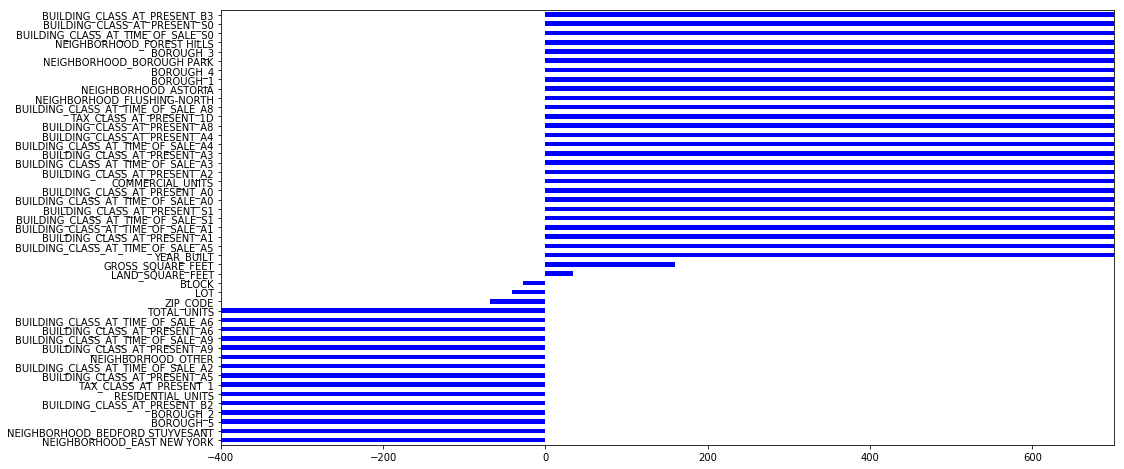

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


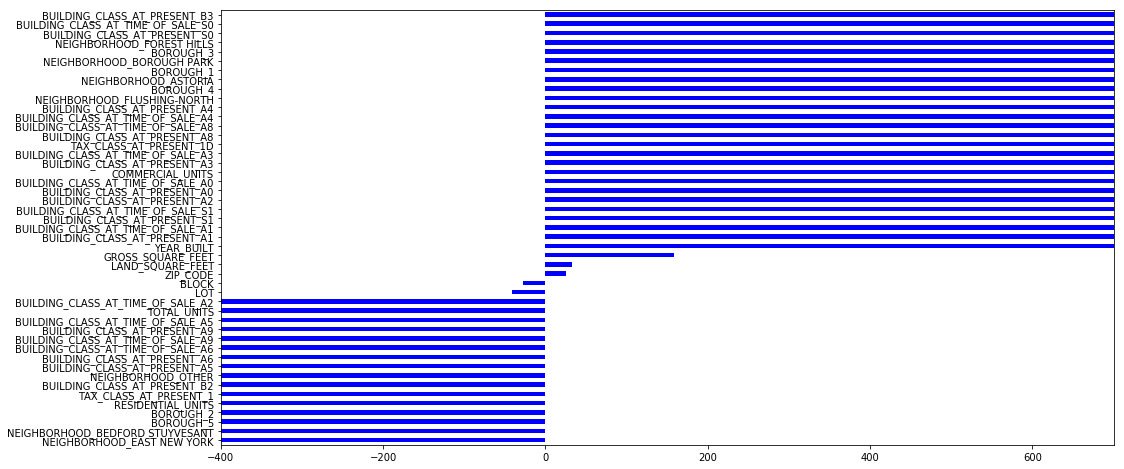

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


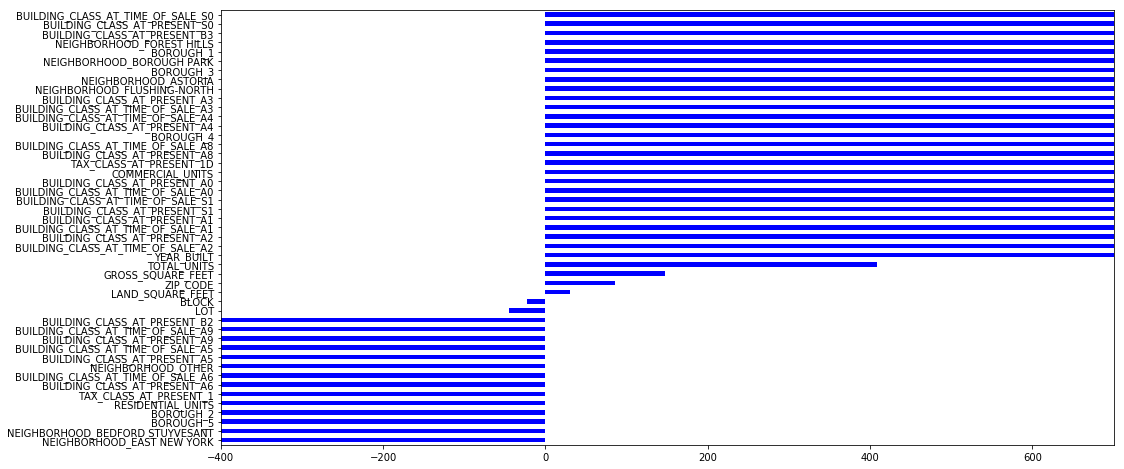

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


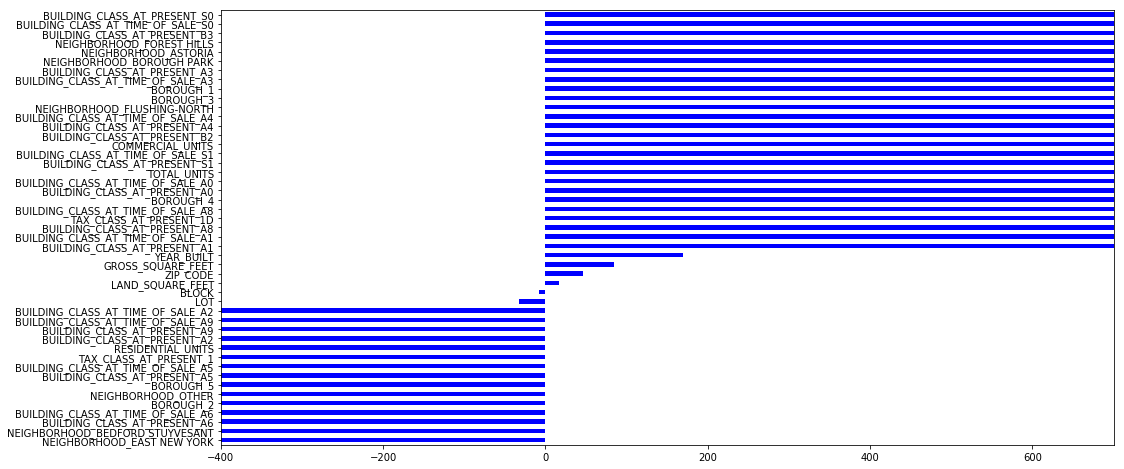

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


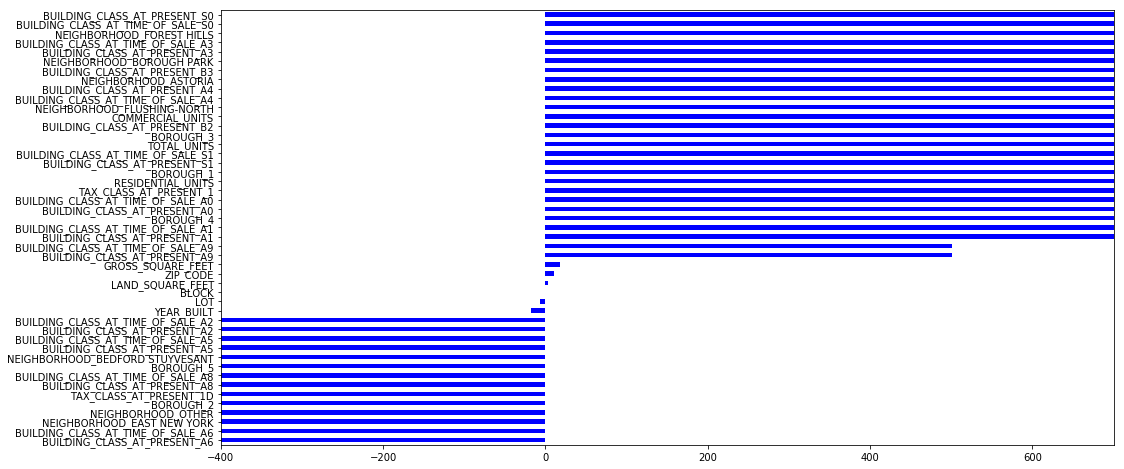

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


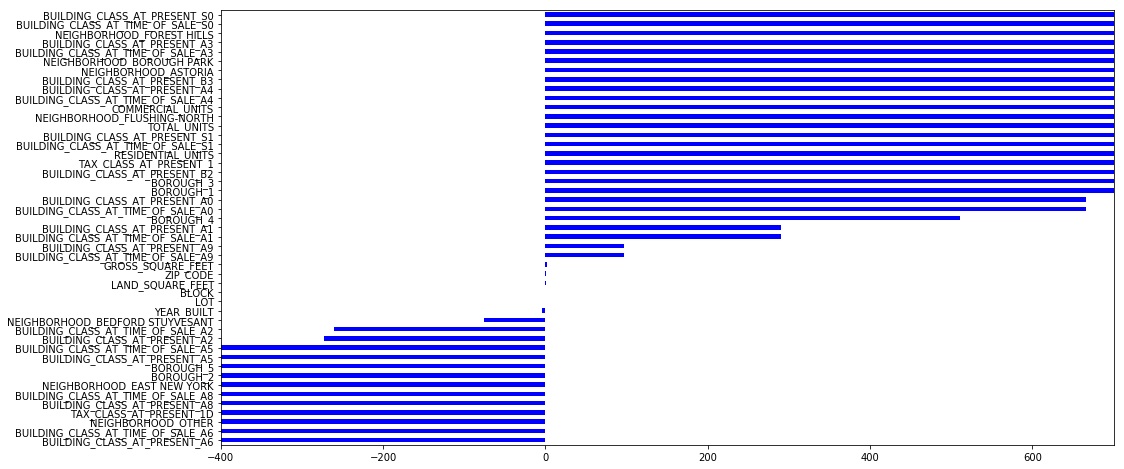

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


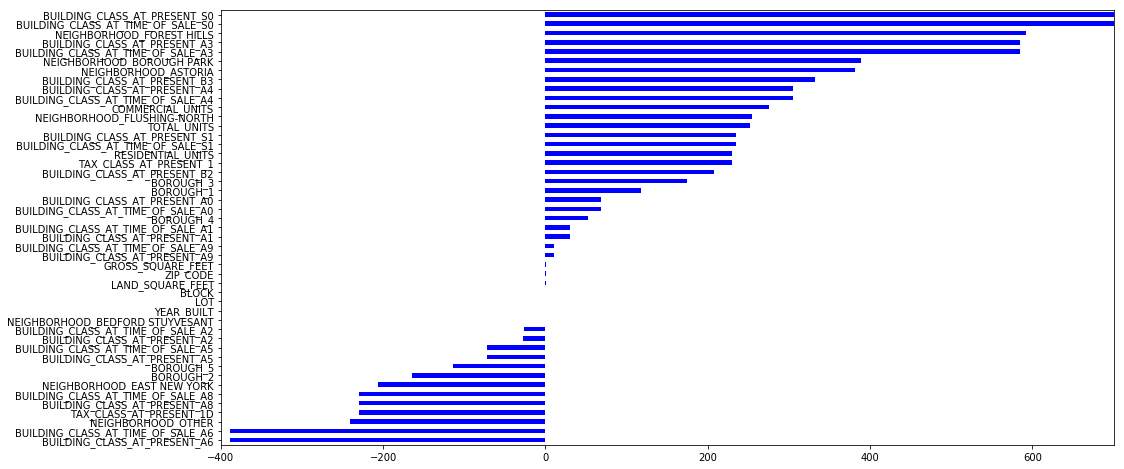

In [35]:
### Ridge regression multiple features

for alpha in [0.001, 0.01, 0.1,1.0,10.0,100.0,1000.0]:

  #fit Ridge Regression model
  display(HTML(f'Ridge Regression with alpha={alpha:.3f}'))
  model = Ridge(alpha=alpha, normalize=True)
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)

  #Get Test MAE
  mae = mean_absolute_error(y_test,y_pred)
  display(HTML(f'The Mean Absolut Error is ${mae:.2f}'))

  #Plot coeficientes
  coefficients = pd.Series(model.coef_,X_train.columns)
  plt.figure(figsize=(16,8))
  coefficients.sort_values().plot.barh(color='blue')
  plt.xlim(-400,700)
  plt.show();



##Draft

In [29]:
dfA[features].head()


,BOROUGH,NEIGHBORHOOD,TAX_CLASS_AT_PRESENT,BLOCK,LOT,BUILDING_CLASS_AT_PRESENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,BUILDING_CLASS_AT_TIME_OF_SALE
0,3,OTHER,1,5495,801,A9,11230.0,1.0,0.0,1.0,6800,1325.0,1930.0,A9
1,4,OTHER,1,7918,72,A1,11427.0,1.0,0.0,1.0,4000,2001.0,1940.0,A1
2,2,OTHER,1,4210,19,A1,10461.0,1.0,0.0,1.0,3500,2043.0,1925.0,A1
3,3,OTHER,1,5212,69,A1,11226.0,1.0,0.0,1.0,4000,2680.0,1899.0,A1
4,3,OTHER,1,7930,121,A5,11203.0,1.0,0.0,1.0,1710,1872.0,1940.0,A5


In [30]:
##The share of each Borough.

df['BOROUGH'].value_counts(normalize=True)*100

4    32.559254
3    28.764378
1    20.839143
2     9.528581
5     8.308644
Name: BOROUGH, dtype: float64